# 트리 모델의 변수중요도



## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

### 2) 데이터 로딩

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 생성

In [3]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비


### 1) x, y로 나누기

In [4]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

### 3) train : validation 분할

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)
x_train.shape

(404, 12)

## 3.Feature Importance

### 1) Decision Tree

In [7]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import *

* 기본 모델

In [8]:
model = DecisionTreeRegressor(max_depth = 3)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

* 모델 시각화

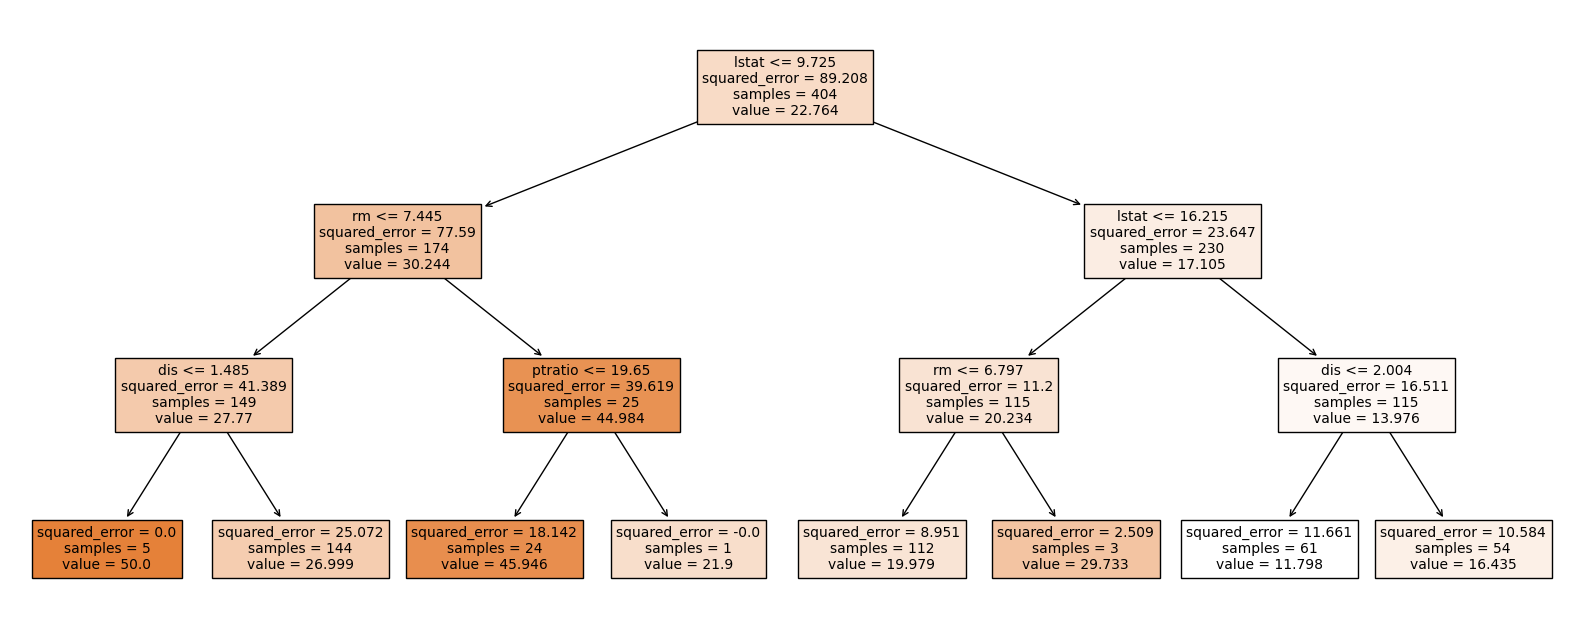

In [9]:
plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10)
plt.show()

* 변수 중요도

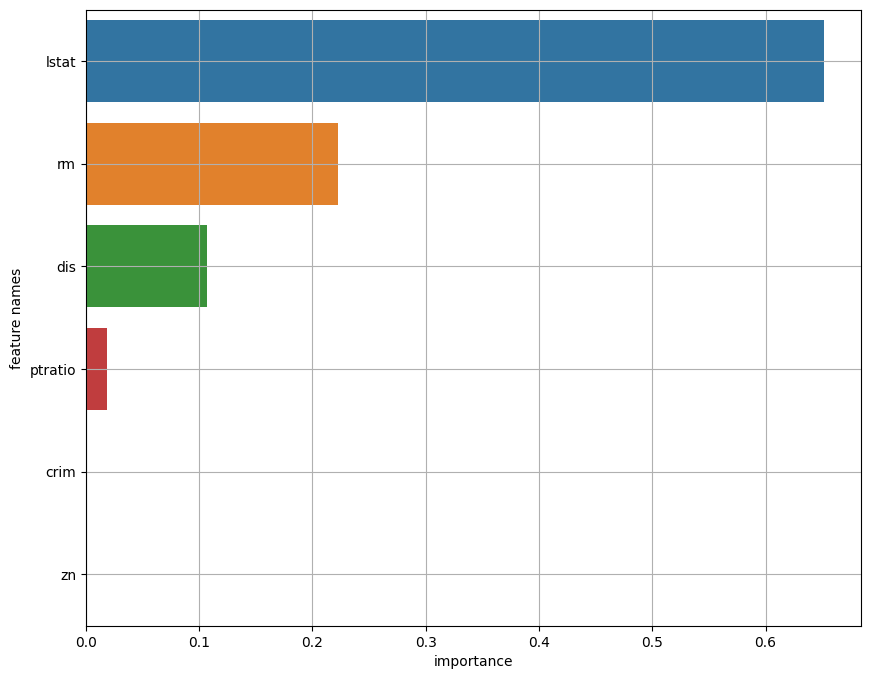

In [10]:
result = plot_feature_importance(model.feature_importances_, list(x), 6)

In [11]:
result

,feature_names,feature_importance
0,lstat,0.651574
1,rm,0.222928
2,dis,0.106809
3,ptratio,0.018688
4,crim,0.000000
5,zn,0.000000


* 성능 최적화 이후 변수 중요도 다시 확인

In [12]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':range(1, 10)}
model = DecisionTreeRegressor()
model_gs = GridSearchCV(model, params, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10)})

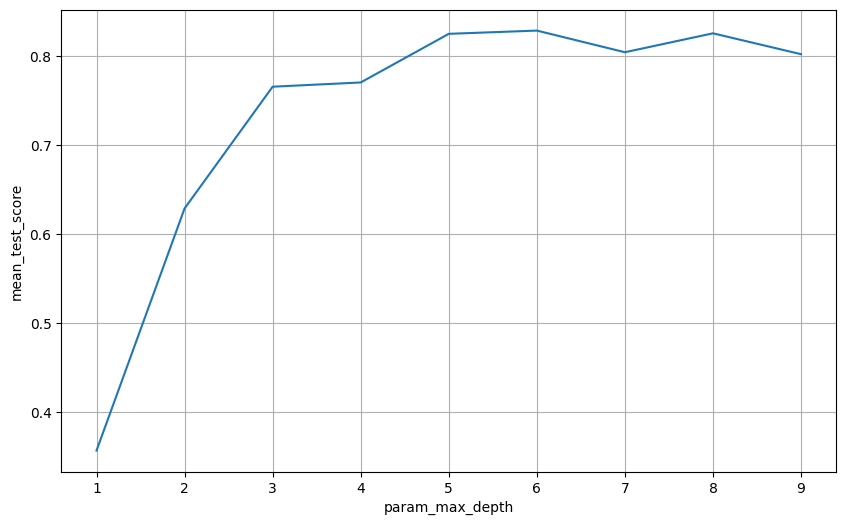

In [13]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model_gs.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

In [14]:
best_model = model_gs.best_estimator_

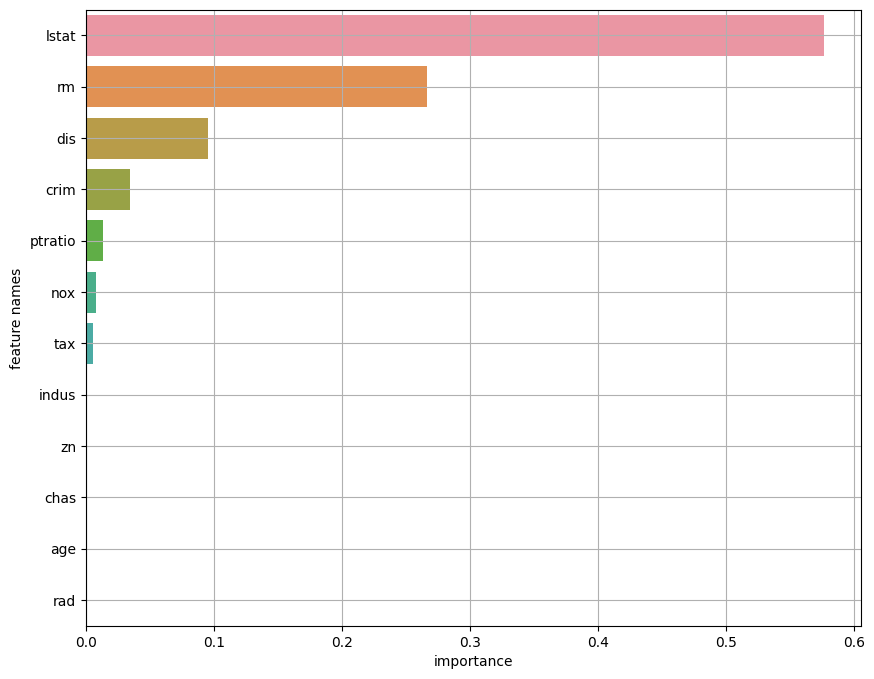

In [15]:
result = plot_feature_importance(best_model.feature_importances_, list(x),12)

In [16]:
# pred = model_gs.predict(x_val)
pred = best_model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.8758794837128825


### 2) Random Forest

* 기본모델링

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
n_est = 3
model = RandomForestRegressor(n_estimators = n_est, max_depth = 2)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=3)

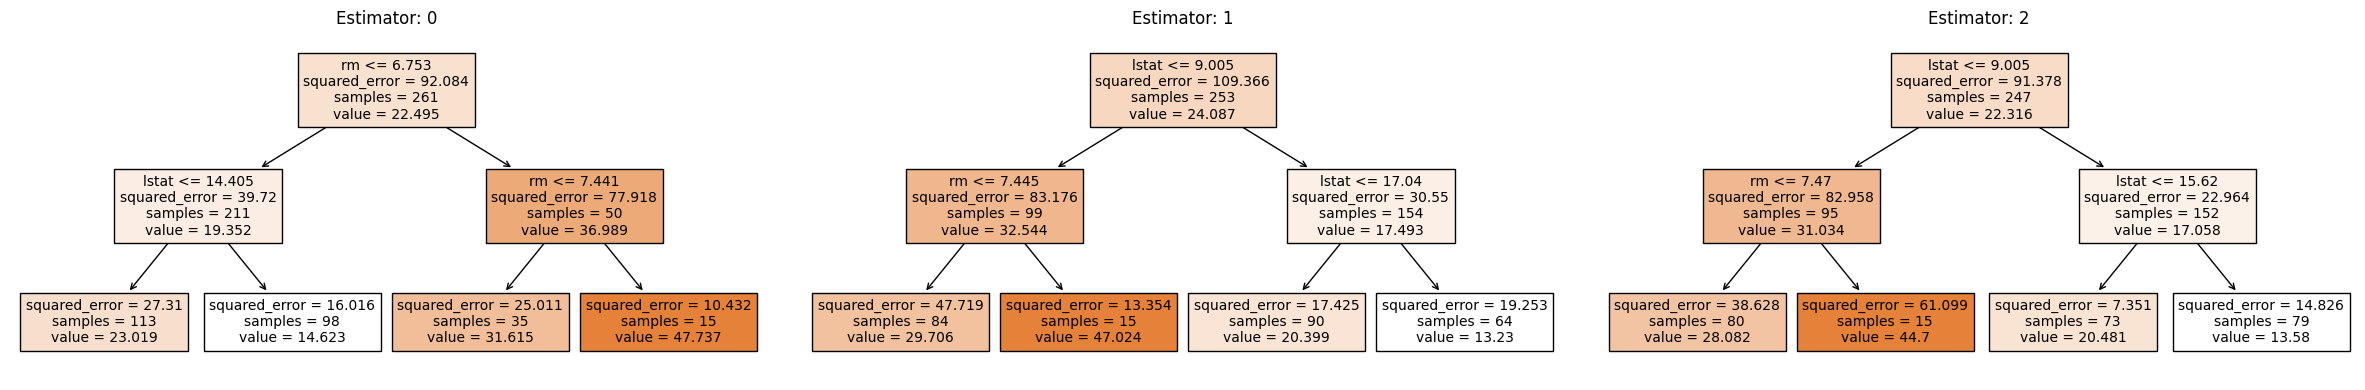

In [19]:
fn=list(x_train)
cn=["0","1"]
fig, axes = plt.subplots(nrows = 1,ncols = n_est,figsize = (24,4))
for index in range(0, n_est):
    plot_tree(model.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True, fontsize = 10,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)

plt.tight_layout()
plt.show()

In [20]:
fi = x_train.iloc[0:0]
for i in range(n_est) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [21]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.796696,0.0,0.0,0.0,0.0,0.0,0.203304
1,0.0,0.0,0.0,0.0,0.0,0.223012,0.0,0.0,0.0,0.0,0.0,0.776988
2,0.0,0.0,0.0,0.0,0.0,0.221739,0.0,0.0,0.0,0.0,0.0,0.778261


In [22]:
fi.mean(axis = 0)

crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
rm         0.413815
age        0.000000
dis        0.000000
rad        0.000000
tax        0.000000
ptratio    0.000000
lstat      0.586185
dtype: float64

In [23]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.413815,0.0,0.0,0.0,0.0,0.0,0.586185


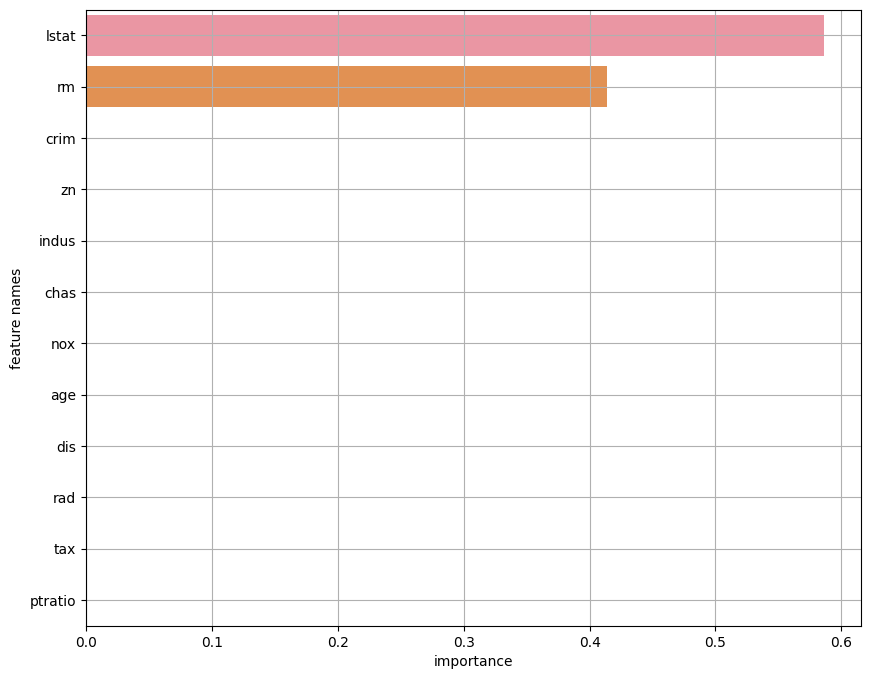

In [24]:
result = plot_feature_importance(model.feature_importances_, list(x))

* tree = 100개 Random Forest 모델 만들기

In [25]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

* 트리 전체 중요도 저장

In [26]:
fi = x_train.iloc[0:0]
for i in range(100) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [27]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.024655,1.046865e-03,0.003222,0.000140,0.033927,0.613709,0.008550,0.054302,0.000289,0.025493,0.024665,0.210002
1,0.095934,3.130794e-03,0.006988,0.000452,0.008527,0.281310,0.012418,0.022677,0.001247,0.012601,0.007678,0.547037
2,0.046497,1.844338e-03,0.004096,0.000093,0.005015,0.618111,0.009064,0.094034,0.001688,0.007393,0.017221,0.194944
3,0.018473,2.539800e-04,0.011215,0.000336,0.074652,0.245969,0.005337,0.064496,0.000981,0.001042,0.037203,0.540042
4,0.058513,4.103340e-03,0.008055,0.000000,0.038182,0.220839,0.011406,0.009866,0.002306,0.010454,0.008397,0.627878
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.060805,2.866295e-07,0.017517,0.001221,0.029868,0.546792,0.005911,0.132713,0.000565,0.002359,0.007633,0.194617
96,0.016062,1.467977e-03,0.002706,0.000294,0.009788,0.293452,0.004546,0.073960,0.004213,0.010232,0.029139,0.554140
97,0.011573,7.720060e-04,0.000173,0.000092,0.026065,0.278586,0.008581,0.074046,0.002348,0.003202,0.007577,0.586985
98,0.043918,1.163636e-03,0.004263,0.000477,0.015423,0.214724,0.010048,0.031901,0.012275,0.001935,0.005324,0.658548


* 트리 100개의 평균 중요도

In [28]:
fi.mean(axis = 0)

crim       0.038504
zn         0.001593
indus      0.005252
chas       0.000506
nox        0.021494
rm         0.394012
age        0.016022
dis        0.065439
rad        0.003136
tax        0.012304
ptratio    0.014665
lstat      0.427073
dtype: float64

In [29]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.038504,0.001593,0.005252,0.000506,0.021494,0.394012,0.016022,0.065439,0.003136,0.012304,0.014665,0.427073


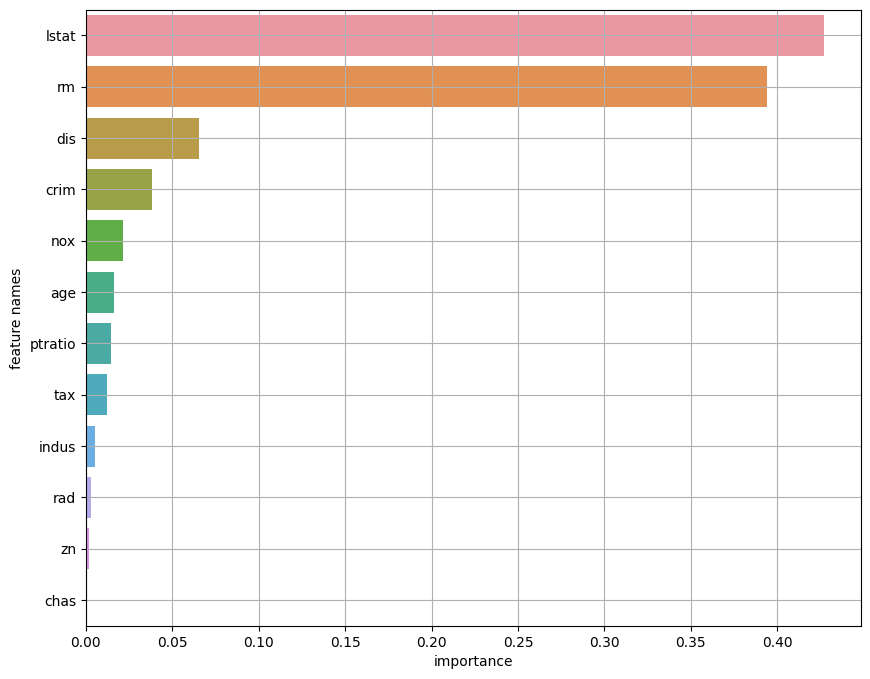

In [30]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [31]:
pred = model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.485401960784312


### 3) XGB

In [32]:
from xgboost import XGBRegressor, plot_tree, plot_importance

* 기본 모델링

In [33]:
model = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

* plot tree
    * plot tree함수는 XGB에서 제공합니다.
    * XGB에서의 트리 시각화는 여러 estimator중 하나씩만 가능합니다.

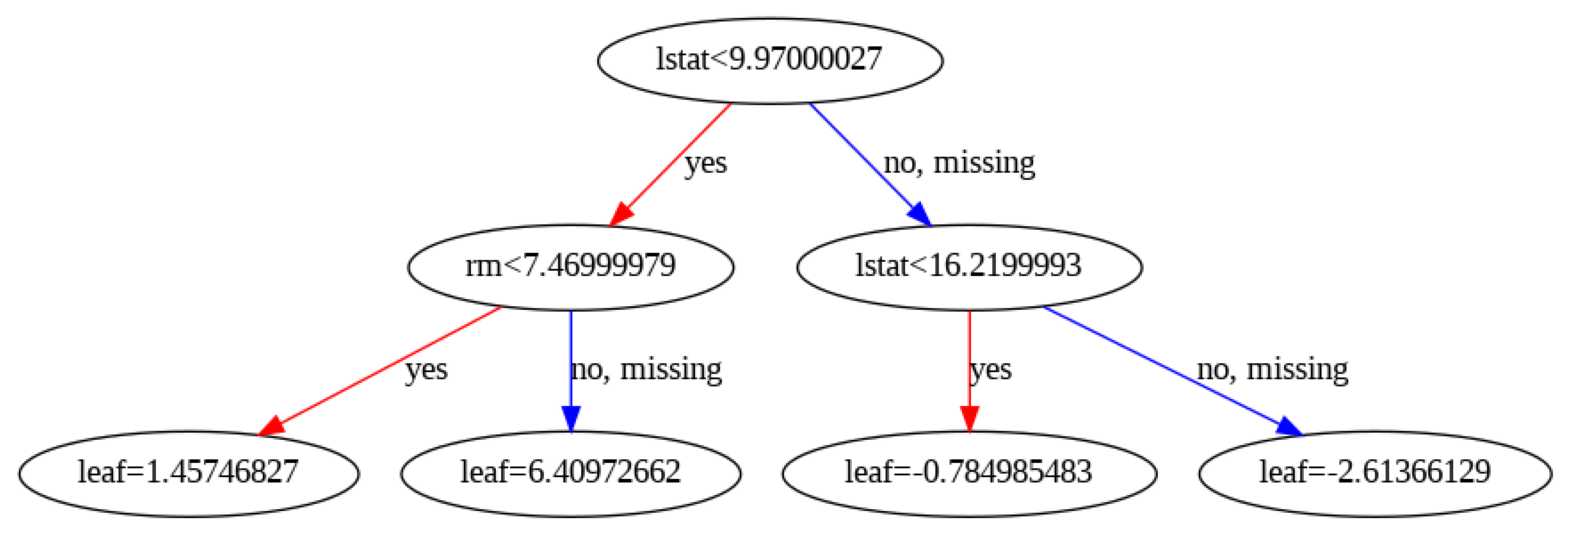

In [34]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model)
plt.show()

* leaf 노드의 값 ==> 로지스틱 함수에 넣으면 0~1 사이의 값으로 변환됨.

* 몇가지 옵션
    * num_trees = 0
    * rankdir='LR'

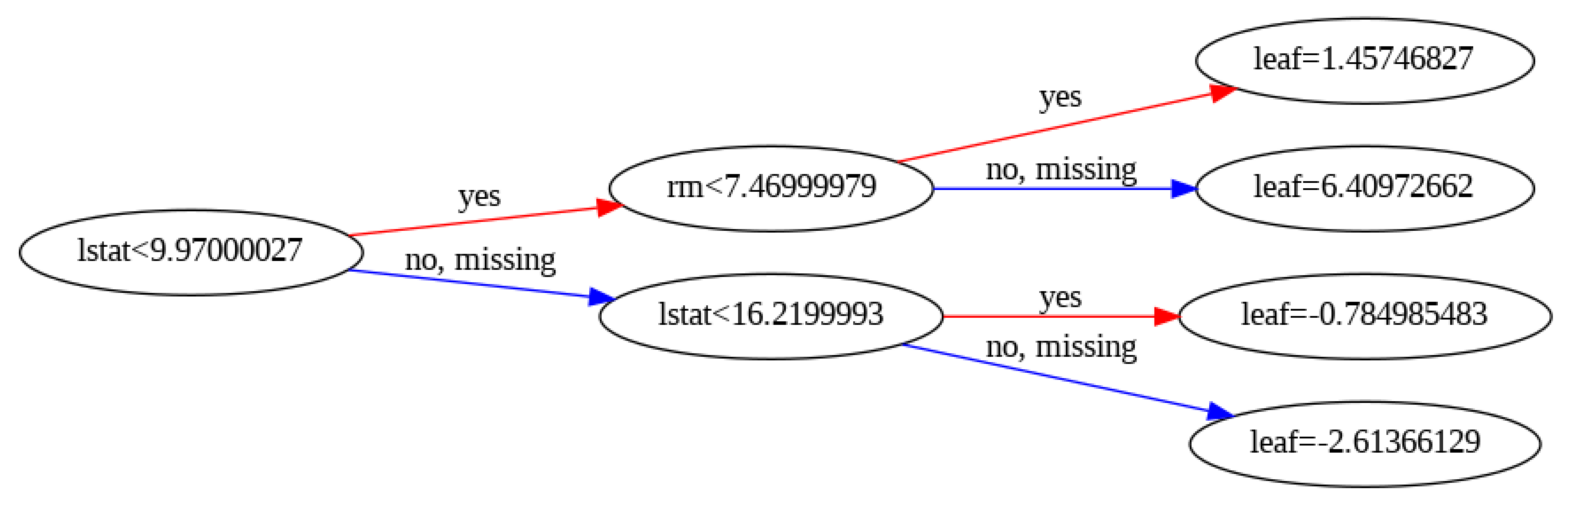

In [35]:
plot_tree(model, num_trees = 0, rankdir = 'LR')
plt.show()

* plot_importance
    * 변수중요도 기본값은 weight

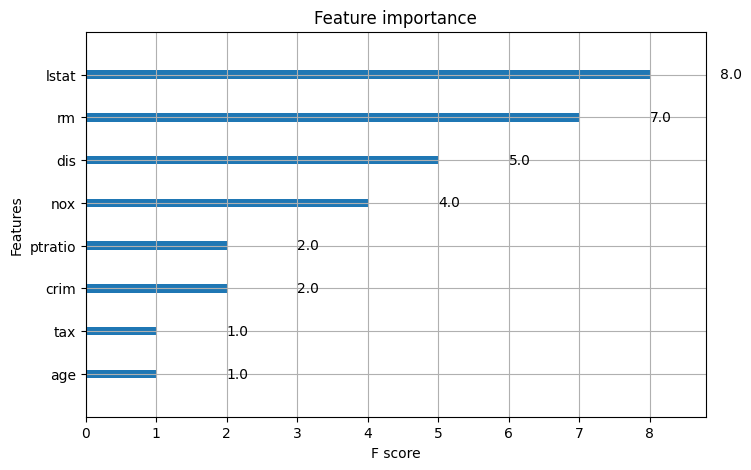

In [36]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model)
plt.show()

* model.feature_importances_ : 변수중요도 기본값은 gain.

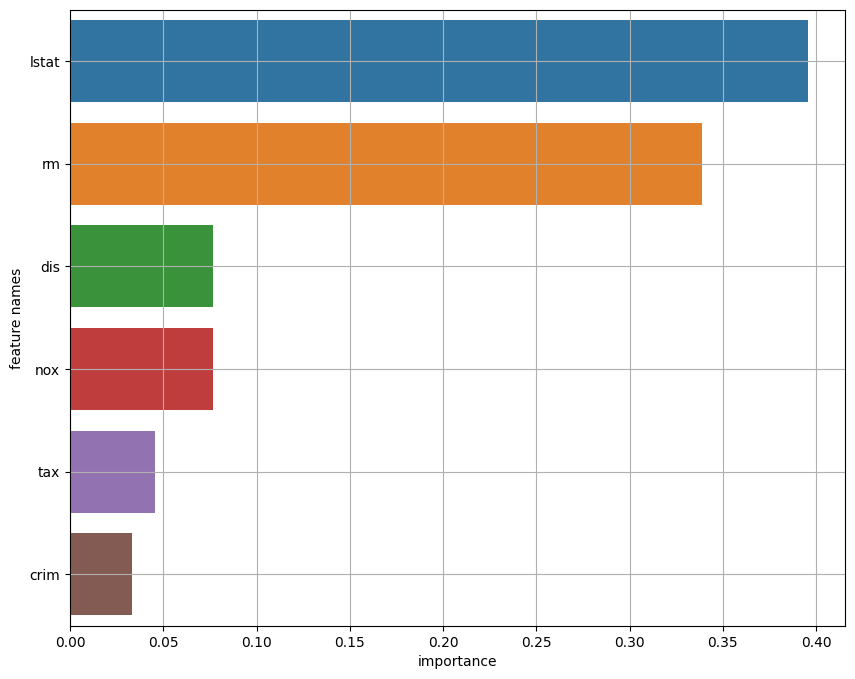

In [37]:
result = plot_feature_importance(model.feature_importances_, list(x),6)

* xgb의 변수 중요도
    * weight : 모델 전체에서 해당 feature가 split될 때 사용된 횟수의 합(plot_tree 에서의 기본값)
    * gain : feature별 평균 imformation gain.(model.feature_importances_ 의 기본값)
    * cover : feature가 split 할때의 샘플 수의 평균.

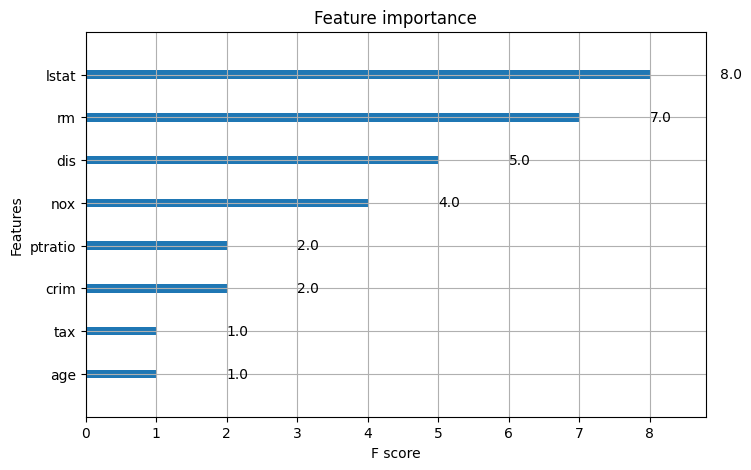

In [38]:
# importance_type='weight'
plot_importance(model)
plt.show()

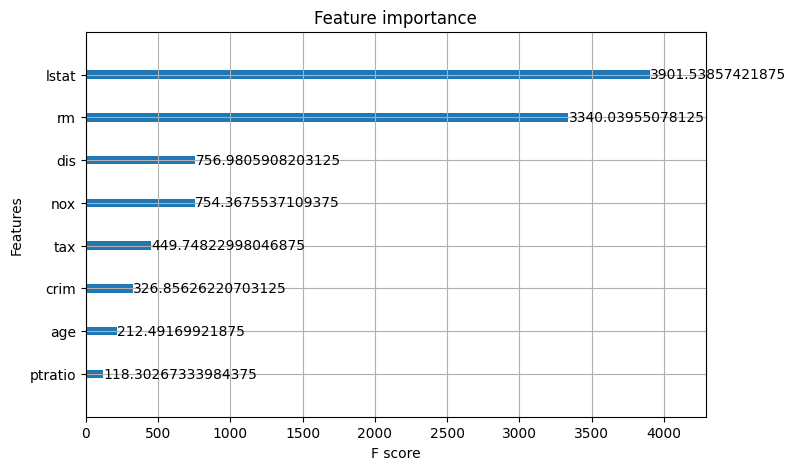

In [39]:
# importance_type='gain'
plot_importance(model, importance_type='gain')
plt.show()

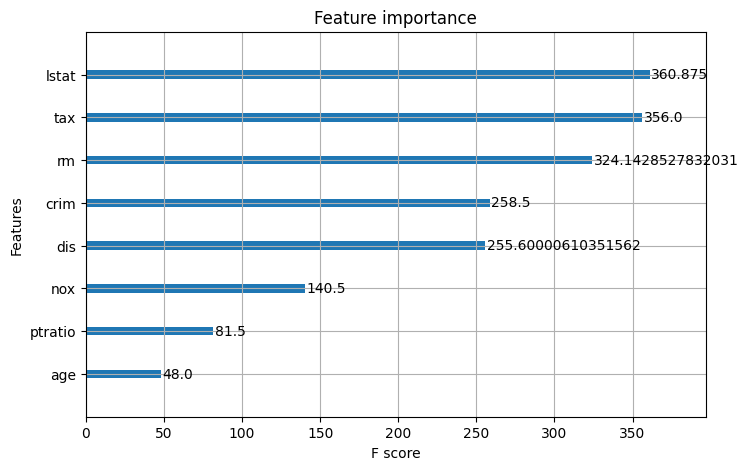

In [40]:
# importance_type='cover'
plot_importance(model, importance_type='cover')
plt.show()

## 4.실습 : 직원 이직 예측모델 변수 중요도 비교

### 1) 데이터 준비

* 데이터 로딩

In [41]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)
data.head(10)

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1
5,0,44,Research & Development,2,1,Medical,Male,Manufacturing Director,3,Single,10209,5,2,16,2,2,2
6,0,41,Sales,10,2,Life Sciences,Male,Sales Executive,4,Single,6230,7,4,16,3,3,14
7,0,25,Sales,18,1,Life Sciences,Male,Sales Executive,3,Married,6232,2,2,6,3,2,3
8,0,50,Research & Development,2,3,Medical,Male,Research Director,3,Married,17639,5,4,30,3,3,4
9,0,47,Sales,4,2,Life Sciences,Female,Sales Executive,4,Single,4163,1,3,9,0,3,9


|	변수 명	|	내용	|	구분	|
|	----	|	----	|	----	|
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|
|	Age	|	나이	|	숫자	|
|	BusinessTravel	|	출장 빈도(범주)	|		|
|	Department	|	현 부서	|		|
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|
|	EducationField	|	전공	|		|
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|
|	Gender	|	성별	|		|
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	JobRole	|	직무	|		|
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	MaritalStatus	|	결혼상태	|		|
|	MonthlyIncome	|	월급	|	숫자	|
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|


In [42]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [43]:
y.value_counts(normalize = True)

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

* 가변수화 Dummy Variable

In [44]:
dummy_vars = ['Department','EducationField','Gender','JobRole','MaritalStatus'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True)

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 20)

In [47]:
print(x_train.shape, x_val.shape)

(920, 29) (230, 29)


* class balance를 맞추기 위한 resampling

In [48]:
from imblearn.over_sampling import SMOTE

In [49]:
smote = SMOTE()
sm_x_train, sm_y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(sm_y_train))
print(np.bincount(sm_y_train) / sm_y_train.shape[0])

[842 842]
[0.5 0.5]


### 2) 모델링 with Resampling
> * Resampling(up) 샘플링 데이터를 이용
* DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성
* validate set으로 예측하고 평가(classification report)해 봅시다.
* 각각의 변수중요도 비교하기.



* 모델링
    * DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성
    * sm_x_train, sm_y_train 으로 모델 학습

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

* decision tree

In [57]:
# depth의 범위 1~10까지 안에서 그리드서치로 튜닝해 봅시다.

params = {'max_depth':range(1,11)}

dt = DecisionTreeClassifier()
model1 = GridSearchCV(dt, params, cv=5,)
model1.fit(sm_x_train, sm_y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 11)})

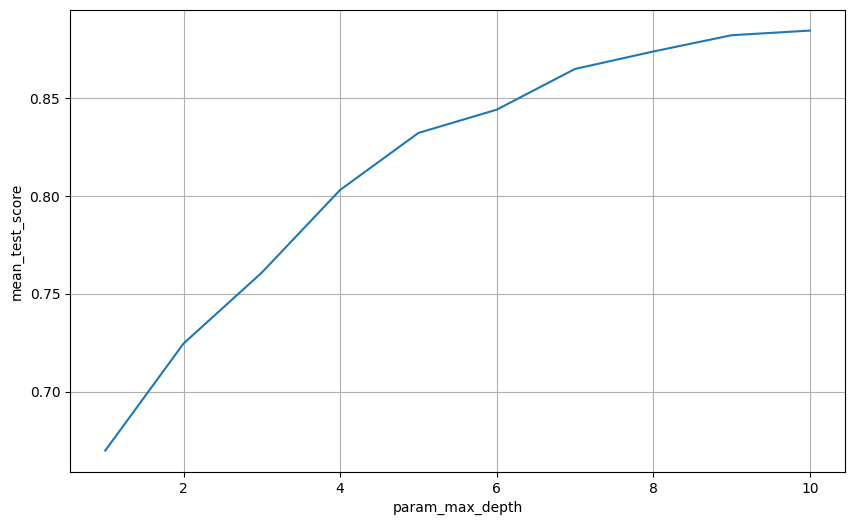

In [58]:
# 튜닝 과정 로그를 df로 저장 합시다.
result = pd.DataFrame(model1.cv_results_)

# 튜닝 결과를 그래프로 그려봅시다.
plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

* rf

In [53]:
# 기본값으로 모델을 생성합니다.
model2 = RandomForestClassifier()
model2.fit(sm_x_train, sm_y_train)

RandomForestClassifier()

* xgb

In [56]:
# 다음 범위 안에서 그리드서치 튜닝을 진행합시다.
# max_depth : 1 ~ 6, learning_rate : 0.01 ~ 0.4, n_estimators : 50 ~ 150

params = {'max_depth':range(1,7),
          'learning_rate':np.arange(0.01, 0.4, 0.05),
          'n_estimators':range(50,151,10)}
xgb=XGBClassifier()
model3 = GridSearchCV(xgb, params, cv=5)
model3.fit(sm_x_train, sm_y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36]),
                         'max_depth': range(1, 7),
                         'n_estimators': range(50, 151, 10)})

* 모델 성능 비교
    * 세 모델 중 성능이 가장 좋은 모델은?

In [66]:
y_pred1 = model1.predict(x_val)
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       208
           1       0.06      0.09      0.08        22

    accuracy                           0.79       230
   macro avg       0.48      0.48      0.48       230
weighted avg       0.82      0.79      0.80       230



In [67]:
y_pred2 = model2.predict(x_val)
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       208
           1       0.27      0.14      0.18        22

    accuracy                           0.88       230
   macro avg       0.59      0.55      0.56       230
weighted avg       0.85      0.88      0.86       230



In [68]:
y_pred3 = model3.predict(x_val)
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       208
           1       0.42      0.23      0.29        22

    accuracy                           0.90       230
   macro avg       0.67      0.60      0.62       230
weighted avg       0.87      0.90      0.88       230



In [ ]:
#xgb모델이 성능이 가장 좋다.

### 3) 변수 중요도 비교
* 세 모델간 변수 중요도를 비교해 봅시다.
* plot_feature_importance 함수 이용하기

,feature_names,feature_importance
0,MonthlyIncome,0.162680
1,MaritalStatus_Married,0.144196
2,RelationshipSatisfaction,0.128322
3,EducationField_Life Sciences,0.084864
4,EducationField_Medical,0.068482
5,TotalWorkingYears,0.053716
6,JobSatisfaction,0.045714
7,Age,0.033618
8,YearsAtCompany,0.031434
9,WorkLifeBalance,0.029991


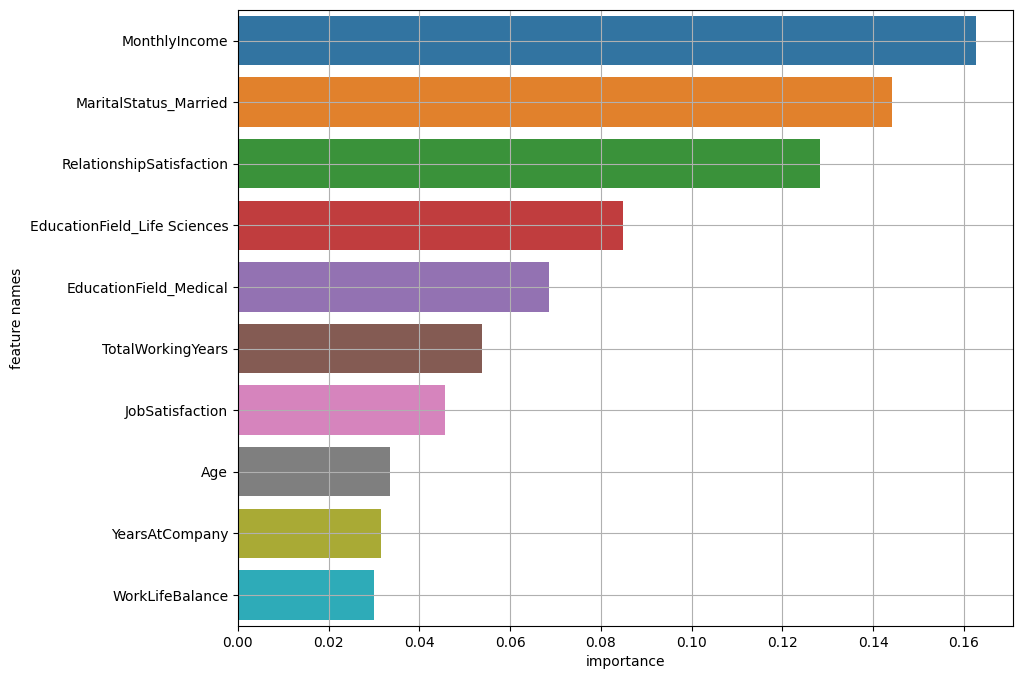

In [70]:
best_model1 = model1.best_estimator_
plot_feature_importance(best_model1.feature_importances_, list(x), 10)

,feature_names,feature_importance
0,MonthlyIncome,0.130225
1,Age,0.073661
2,MaritalStatus_Married,0.072423
3,RelationshipSatisfaction,0.072352
4,TotalWorkingYears,0.050476
5,JobSatisfaction,0.047678
6,Department_Research & Development,0.047418
7,TrainingTimesLastYear,0.047184
8,Education,0.046373
9,EducationField_Medical,0.045587


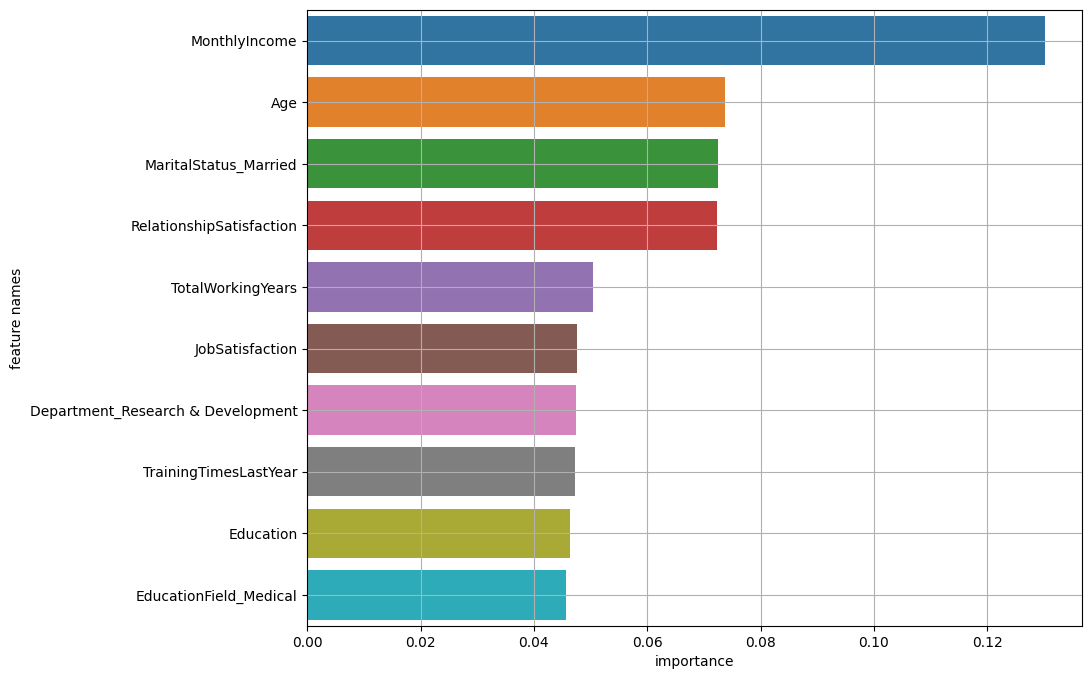

In [72]:
plot_feature_importance(model2.feature_importances_, list(x), 10)

,feature_names,feature_importance
0,MaritalStatus_Married,0.131642
1,Department_Sales,0.081276
2,EducationField_Other,0.068036
3,JobRole_Research Scientist,0.058697
4,EducationField_Medical,0.058407
5,JobRole_Human Resources,0.057784
6,RelationshipSatisfaction,0.055573
7,Department_Research & Development,0.053807
8,JobRole_Laboratory Technician,0.053713
9,EducationField_Life Sciences,0.051184


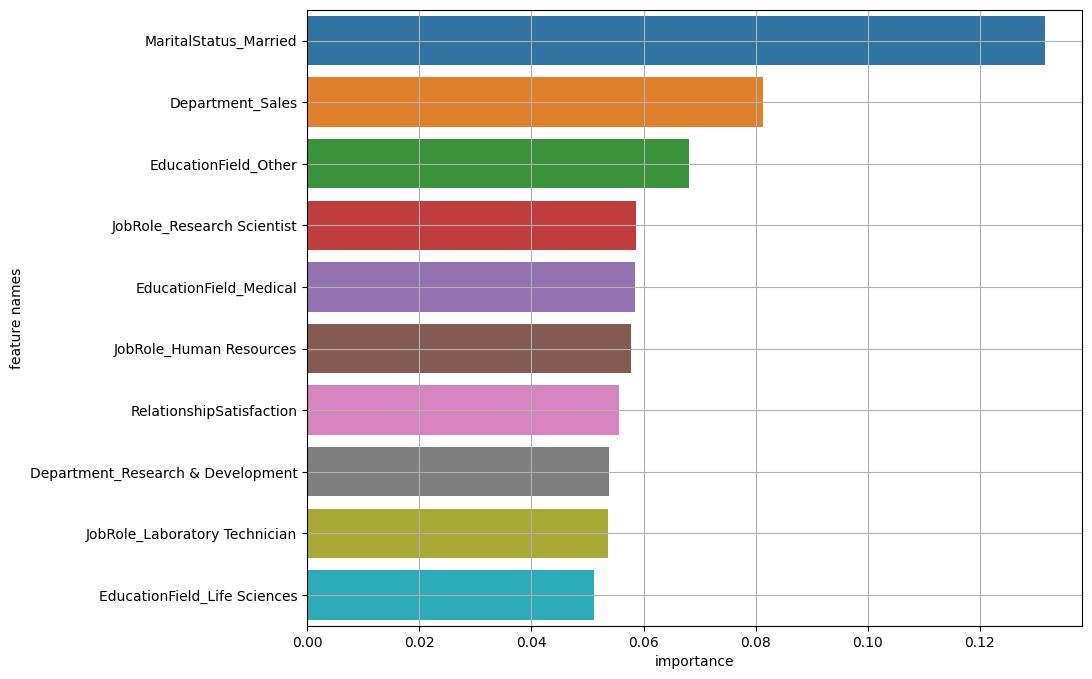

In [73]:
best_model3 = model3.best_estimator_
plot_feature_importance(best_model3.feature_importances_, list(x), 10)

______
